In [14]:
from core.semcor_bert_pipeline import *
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('../data/rabagliati_2013_stimuli.csv')
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
tokenize_ctx = lambda t: tokenizer.tokenize(t)
df['tokenized_dis_ctx'] = df['dis_ctx'].apply(tokenize_ctx)

In [53]:
len(df['target'].unique())

25

In [4]:
model = initialize_model()

In [5]:
df = df[~df['target'].isin(['moose', 'mousse'])] #BERT tokenization issues

In [158]:
df

,sentence_ctx,rel_type,s1,s2,target,dis_ctx,tokenized_dis_ctx
0,curr,reg_pol,Barney was on vacation.,"He fed a chicken, which was fun.",chicken,fed,[fed]
1,curr,reg_pol,Barney was on vacation.,"He roasted a chicken, which was fun.",chicken,roasted,[roasted]
2,prev,reg_pol,Barney was playing at a farm.,The chicken was nice.,chicken,playing at a farm,"[playing, at, a, farm]"
3,prev,reg_pol,Barney was at a supermarket.,The chicken was nice.,chicken,at a supermarket,"[at, a, supermarket]"
4,curr,reg_pol,Oscar was at the beach.,"He caught a fish, which was exciting.",fish,caught,[caught]
...,...,...,...,...,...,...,...
87,prev,hom,Ernie was at a family reunion.,The son was nice.,son,at a family reunion,"[at, a, family, reunion]"
88,curr,hom,Bert was at a dance.,"He dressed up as a knight, which was cool.",knight,dressed up as,"[dressed, up, as]"
89,curr,hom,Bert was at a dance.,"He stayed up for a night, which was cool",night,stayed up for,"[stayed, up, for]"
90,prev,hom,Bert was at a costume party.,The knight was cool.,knight,was at a costume party,"[was, at, a, costume, party]"


In [162]:
bert_data = []
for i in np.arange(0, len(df.index), 4):
    type_stimuli = df.iloc[i:i + 4]
    for sent_ctx in ['curr', 'prev']:
        curr_prev_ctx = type_stimuli[type_stimuli['sentence_ctx'] == sent_ctx]
        for row in curr_prev_ctx.iterrows():
            row = row[1]
            s1, s2, target_token = row['s1'], row['s2'], row['target']
            indexed_tokens, tokenized_text = preprocess(s1, target_token, s2 = s2)
            target_activations, attns = get_model_output(indexed_tokens, model)
            attn_dict = process_raw_attentions([attns], [tokenized_text])[0]
            target_embeddings = sum_layers(target_activations, -4)
            bert_data.append({"attns": attn_dict, "target_embed": target_embeddings, "target_name": target_token,
                             "tokenized_sents": tokenized_text[0], "tokenized_dis": row['tokenized_dis_ctx'],
                             "sent_ctx": sent_ctx})

In [7]:
def find_sub_list(sl,l):
    sll=len(sl)
    for ind in (i for i,e in enumerate(l) if e==sl[0]):
        if l[ind:ind+sll]==sl:
            return ind,ind+sll-1


In [10]:
prev_attn = []
curr_attn = []
prev_layers = []
curr_layers = []
failures = []
prev_attn_ranks = []
curr_attn_ranks = []
prev_rank_layers = []
curr_rank_layers = []
for d in bert_data:
    lex_indices = [i for i in range(len(d['tokenized_sents'])) if d['tokenized_sents'][i] not in ["[CLS]", "[SEP]", ".", ","]]
    lex_tokens = np.array(d['tokenized_sents'])[lex_indices]
    dis_indices = find_sub_list(d['tokenized_dis'], lex_tokens.tolist())
    if dis_indices is not None:
        dis_start = dis_indices[0]
        dis_end = dis_indices[1] + 1
        target_indices = np.arange(dis_start, dis_end)
        for layer in d['attns']:
            a = d['attns'][layer][lex_indices]
            summed_attns = np.sum(a[dis_start:dis_end])
            attn_ranks = [i / len(lex_tokens) for i in np.arange(len(a)) if np.argsort(a)[i] in target_indices]
            if d['sent_ctx'] == 'prev':
                prev_attn.append(summed_attns)
                prev_attn_ranks += attn_ranks
                prev_rank_layers += [layer] * len(attn_ranks)
                prev_layers.append(layer)
            if d['sent_ctx'] == 'curr':
                curr_attn.append(summed_attns)
                curr_attn_ranks += attn_ranks
                curr_rank_layers += [layer] * len(attn_ranks)
                curr_layers.append(layer)
    else:
        failures.append((d['tokenized_dis'], d['tokenized_sents']))

Text(0.5, 1, 'Normalized Ranks of Disambiguating Tokens')

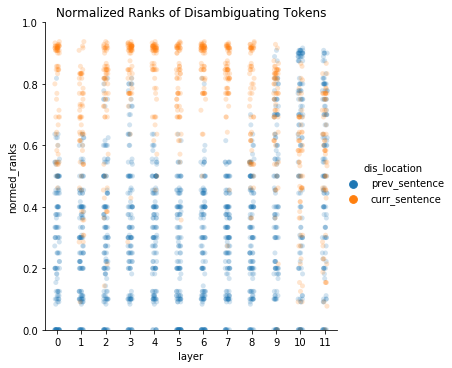

In [15]:
attn_ranks = pd.DataFrame({"layer": prev_rank_layers + curr_rank_layers, "normed_ranks": prev_attn_ranks + curr_attn_ranks,
              "dis_location": (["prev_sentence"] * len(prev_rank_layers)) + (['curr_sentence'] * len(curr_rank_layers))})
sns.catplot(x = 'layer', y = 'normed_ranks', hue = 'dis_location', data = attn_ranks, alpha = 0.2)
plt.ylim(0, 1)
plt.title("Normalized Ranks of Disambiguating Tokens")

Text(0.5, 1, 'Attention on Disambiguating Tokens')

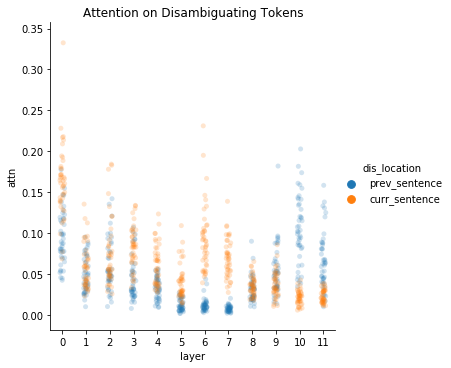

In [16]:
results = pd.DataFrame({"layer": prev_layers + curr_layers, "attn": prev_attn + curr_attn,
              "dis_location": (["prev_sentence"] * len(prev_attn)) + (['curr_sentence'] * len(curr_attn))})
sns.catplot(x = 'layer', y = 'attn', hue = 'dis_location', data = results, alpha = 0.2)
plt.title("Attention on Disambiguating Tokens")

In [17]:
curr_prev_sent = []
for d in bert_data:
    sep_index = d['tokenized_sents'].index("[SEP]")
    for l in d['attns']:
        sum_prev = np.sum(d['attns'][l][1:sep_index - 1])
        sum_curr = np.sum(d['attns'][l][sep_index + 1:-2])
        #sum_prev = np.sum(d['attns'][l][:sep_index + 1])
        #sum_curr = np.sum(d['attns'][l][sep_index + 1:])
        curr_prev_sent.append({"layer": l, 'prior_attn': sum_prev,
                               'target_attn': sum_curr, "sent_ctx": d['sent_ctx']})
        

In [19]:
curr_prev_sent = pd.DataFrame(curr_prev_sent)

curr_prev_sent.groupby('sent_ctx').agg('mean').drop('layer', axis = 1)
#Average attention to sentences, Although the target sentence is attended to more, 
#the previous sentence has more attention if there is disambiguating information

,prior_attn,target_attn
sent_ctx,,
curr,0.056473,0.285316
prev,0.081344,0.193992


In [242]:
curr_prev_sent

,layer,prior_attn,target_attn,sent_ctx
0,0,0.068779,0.627686,curr
1,1,0.038878,0.345148,curr
2,2,0.032662,0.374662,curr
3,3,0.028078,0.322214,curr
4,4,0.016635,0.174049,curr
...,...,...,...,...
1003,7,0.020762,0.277704,prev
1004,8,0.081311,0.163851,prev
1005,9,0.157462,0.168981,prev
1006,10,0.183902,0.126041,prev


Text(0.5, 1, "Attention on First Sentence's Tokens")

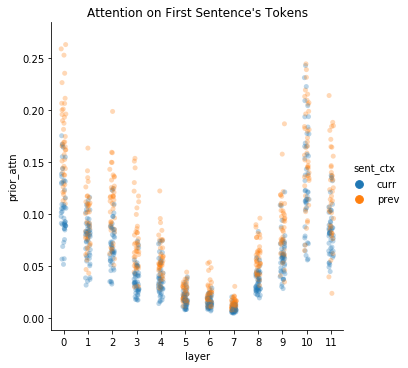

In [20]:
sns.catplot(x = 'layer', y = 'prior_attn', hue = 'sent_ctx', data = curr_prev_sent, alpha = 0.3)
plt.title("Attention on First Sentence's Tokens")

Text(0.5, 1, "Attention on Second Sentence's Tokens")

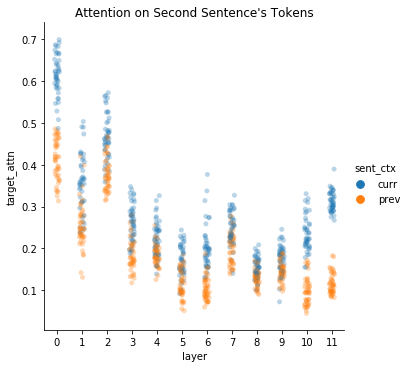

In [21]:
sns.catplot(x = 'layer', y = 'target_attn', hue = 'sent_ctx', data = curr_prev_sent, alpha = 0.3)
plt.title("Attention on Second Sentence's Tokens")

In [392]:
from matplotlib.backends.backend_pdf import PdfPages


Generating a PDF of attention graphs for each sentence

In [400]:
with PdfPages('Rabagliati_etal_2013_attentions.pdf') as pdf:

    for s in bert_data:
        fig = plt.figure(figsize = (30, 20))
        for i in range(1, 13):
            ax = fig.add_subplot(4, 3, i)
            sent_df = pd.DataFrame({"Tokens": s['tokenized_sents'], "Attention": s['attns'][i - 1]})
            ax = sns.barplot(x = sent_df.index, y = "Attention", data = sent_df)
            ax.set_xticklabels(s['tokenized_sents'])
            ax.set_xlabel("Token")
            ax.set_title("Layer " + str(i))
        plt.suptitle("Target: " + s['target_name'] + " Context: " + str(s['tokenized_dis']) + " Context Sentence: " + s['sent_ctx'],
                    fontsize = 18)
        pdf.savefig()
        plt.close()

In [164]:
avg_attn = []
for d in bert_data:
    sentence = d['tokenized_sents']
    target = d['target_name']
    other_indices = [i for i in range(len(sentence)) if d['tokenized_sents'][i] not in ["[CLS]", "[SEP]", target,
                                                                                      ".", ","]]
    other_tokens = np.array(sentence)[other_indices]
    dis_indices = find_sub_list(d['tokenized_dis'], other_tokens.tolist())
    if dis_indices is not None:
        dis_start = dis_indices[0]
        dis_end = dis_indices[1] + 1
        for layer in d['attns']:
            attn_lst = d['attns'][layer][other_indices]
            avg_attn.append({'layer': layer, "avg_attn": np.mean(attn_lst[dis_start:dis_end]),
                             'tokens': 'high_constraining', 'ctx_sentence': d['sent_ctx']})
            avg_attn.append({'layer': layer,
                             "avg_attn": np.mean(attn_lst[:dis_start].tolist() + attn_lst[dis_end:].tolist()),
                 'tokens': 'low_constraining', 'ctx_sentence': d['sent_ctx']})


In [38]:
avg_attn = pd.DataFrame(avg_attn)

Text(0.5, 1.0, 'Global Average Attention on Disambiguating Tokens vs. Others')

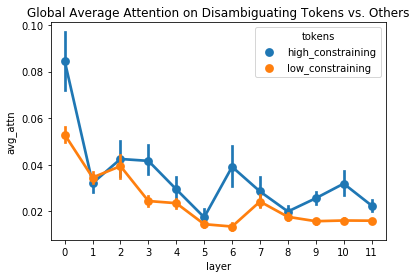

In [43]:
sns.pointplot(x = 'layer', y = 'avg_attn', data = avg_attn, hue = 'tokens')
plt.title("Global Average Attention on Disambiguating Tokens vs. Others")

Text(0.5, 1.0, 'Disambiguating Context in Previous Sentence')

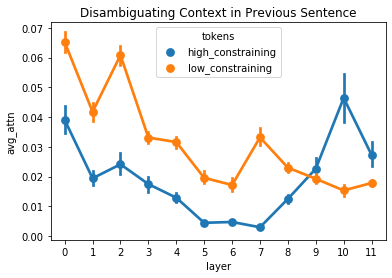

In [49]:
sns.pointplot(x = 'layer', y = 'avg_attn', data = avg_attn[avg_attn['ctx_sentence'] == 'prev'], hue = 'tokens', alpha = 0.1)
plt.title("Disambiguating Context in Previous Sentence")

Text(0.5, 1.0, 'Disambiguating Context in Same Sentence as Target')

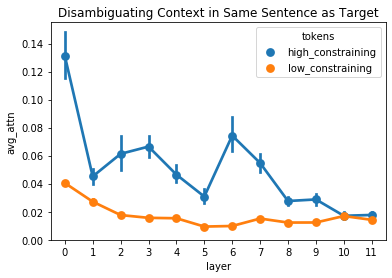

In [50]:
sns.pointplot(x = 'layer', y = 'avg_attn', data = avg_attn[avg_attn['ctx_sentence'] == 'curr'], hue = 'tokens', alpha = 0.1)
plt.title("Disambiguating Context in Same Sentence as Target")

In [165]:
lex_indices = lambda sent, targ: [i for i in range(len(sent)) if sent[i] not in ["[CLS]", "[SEP]", targ,
                                                                                      ".", ","]]


In [166]:
avg_attn_split = []
for d in bert_data:
    sentence = d['tokenized_sents']
    target = d['target_name']
    sep_index = sentence.index("[SEP]")
    prev_sent, prev_indices = np.array(sentence[:sep_index]), lex_indices(sentence[:sep_index], target)
    curr_sent, curr_indices = np.array(sentence[sep_index + 1:]), lex_indices(sentence[sep_index + 1:] , target)
    prev_sent, curr_sent = prev_sent[prev_indices], curr_sent[curr_indices]

    if d['sent_ctx'] == 'curr':
        dis_indices = find_sub_list(d['tokenized_dis'], curr_sent.tolist())
    else:
        dis_indices = find_sub_list(d['tokenized_dis'], prev_sent.tolist())

    if dis_indices is not None:
        dis_start = dis_indices[0]
        dis_end = dis_indices[1] + 1
        for layer in d['attns']:
            attn_lst = d['attns'][layer]
            prev_attns = attn_lst[prev_indices]
            curr_attns = attn_lst[sep_index + 1:][curr_indices]
            if d['sent_ctx'] == 'curr':
                avg_attn_split.append({'layer': layer, "avg_attn": np.mean(prev_attns),
                                 'tokens': 'prev_uninformative', 'ctx_sentence': d['sent_ctx']})
                avg_attn_split.append({'layer': layer,
                                 "avg_attn": np.mean(curr_attns[:dis_start].tolist() + curr_attns[dis_end:].tolist()),
                     'tokens': 'curr_uninformative', 'ctx_sentence': d['sent_ctx']})
                avg_attn_split.append({'layer': layer,
                             "avg_attn": np.mean(curr_attns[dis_start:dis_end]),
                 'tokens': 'curr_disambig', 'ctx_sentence': d['sent_ctx']})
            if d['sent_ctx'] == 'prev':
                avg_attn_split.append({'layer': layer, "avg_attn": np.mean(prev_attns[dis_start:dis_end]),
                 'tokens': 'prev_disambig', 'ctx_sentence': d['sent_ctx']})
                avg_attn_split.append({'layer': layer,
                                 "avg_attn": np.mean(prev_attns[:dis_start].tolist() + prev_attns[dis_end:].tolist()),
                     'tokens': 'prev_uninformative', 'ctx_sentence': d['sent_ctx']})
                avg_attn_split.append({'layer': layer, "avg_attn": np.mean(curr_attns),
                 'tokens': 'curr_uninformative', 'ctx_sentence': d['sent_ctx']})

avg_attn_split = pd.DataFrame(avg_attn_split)

Text(0.5, 1.0, 'Disambiguating Context in Previous Sentence')

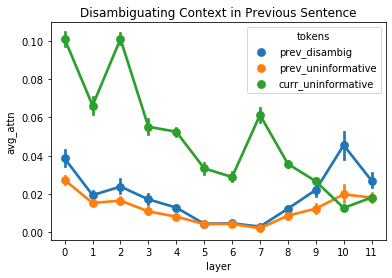

In [167]:
sns.pointplot(x = 'layer', y = 'avg_attn', data = avg_attn_split[avg_attn_split['ctx_sentence'] == 'prev'], hue = 'tokens', alpha = 0.1)
plt.title("Disambiguating Context in Previous Sentence")

Text(0.5, 1.0, 'Disambiguating Context in Same Sentence as Target')

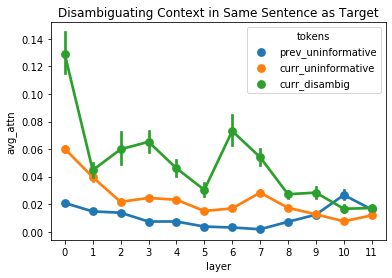

In [168]:
sns.pointplot(x = 'layer', y = 'avg_attn', data = avg_attn_split[avg_attn_split['ctx_sentence'] == 'curr'], hue = 'tokens', alpha = 0.1)
plt.title("Disambiguating Context in Same Sentence as Target")

In [176]:
bert_data[0].keys()

dict_keys(['attns', 'target_embed', 'target_name', 'tokenized_sents', 'tokenized_dis', 'sent_ctx'])

In [212]:
[i for i in itertools.combinations(np.arange(4), 2)]

[(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3)]

In [218]:
any([3 > 1, 4 > 1, 5 > 1])

True

In [288]:
def compare_sim(query, others, lst):
    find_sim = lambda l, q: [t[1] for t in l if t[0] == q] 
    query_sim = find_sim(lst, query)
    return all([query_sim > find_sim(lst, o) for o in others])

In [295]:
import itertools
from core.metrics import cosine_sim

find_sim = lambda l, q: [t[1] for t in l if t[0] == q] 
correct_pairs = 0
correct_indices = []
wrong_pairs = 0
for i in np.arange(0, len(bert_data), 4):
    word_dicts = bert_data[i:i + 4]
    word_embeddings = [d['target_embed'] for d in word_dicts]
    cs_pairs = []
    for j, k in itertools.combinations(np.arange(4), 2):
        cs_pairs.append(((j, k), cosine_sim(word_embeddings[j], word_embeddings[k])))
    sense_1_correct = compare_sim((0, 2), [(0, 1), (0, 3), (1, 2), (2, 3)], cs_pairs)
    sense_2_correct = compare_sim((1, 3), [(0, 1), (1, 2), (0, 3), (2, 3)], cs_pairs)
    if sense_1_correct and sense_2_correct:
        correct_pairs += 2
        correct_indices += [i / 4, i / 4]
    elif sense_1_correct:
        correct_pairs += 1
        correct_indices.append(i / 4)
        wrong_pairs += 1
    elif sense_2_correct:
        correct_pairs += 1
        correct_indices.append(i / 4)
        wrong_pairs += 1
    else:
        wrong_pairs += 2
        
correct_pairs

5

In [299]:
correct_indices

[18.0, 21.0, 21.0, 22.0, 22.0]